<a href="https://colab.research.google.com/github/anisalopezruiz/bio108tutorial/blob/main/Week_10_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish and palm oil streams

Monoculture crops, such as palm oil, are devastating to biodiversity.

Today, we will look at a dataset from [Chua et al. (2020)](https://doi.org/10.1111/fwb.13500) that analyzes fish in streams impacted by palm oil in Malaysia. They analyze how morphological traits of fish may mediate the presence of fish in palm oil impacted streams, meaning which fish persist despite the disturbance from monoculture.

We will use unsupervised machine learning to apply dimensionality reduction, to predict whether fish are found in palm oil streams based on their morphological traits.
With dimensionality reduction, we can turn the data from a high dimensional (many variables) to a low dimensional (fewer variables) space while still retaining meaningful properties of the original data.

These predictions can be useful to predict what species of fish may be more resistant to habitat disturbances from palm oil monoculture.

# Data preparation

## Import libraries

First, we will start importing the necessary libraries

In [2]:
### Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
### Initial imports from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import confusion_matrix

# magic function to force plots to display inline
%matplotlib inline

## Import data

We will import our data. I uploaded the data to a github repository [here](https://github.com/anisalopezruiz/bio108tutorial/blob/main/Endau_data.xlsx). I downloaded the data from [Data Dryad](https://datadryad.org/dataset/doi:10.5061/dryad.tx95x69sw#).

In [60]:
# Storing the github url for the raw data download
url = 'https://github.com/anisalopezruiz/bio108tutorial/raw/refs/heads/main/Endau_data.xlsx'

# use read excel function because this is a .xlsx file
fish = pd.read_excel(url)

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [37]:
# We can see basic information about our dataset using .info()
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SITENAME     415 non-null    object 
 1   Species      415 non-null    object 
 2   BODY_MASS    415 non-null    float64
 3   EYE_POS      415 non-null    float64
 4   EYE_SIZE     415 non-null    float64
 5   BAR_LENGTH   415 non-null    float64
 6   MOUTH_POS    415 non-null    float64
 7   MOUTH_SIZE   415 non-null    float64
 8   COMPRESS     415 non-null    float64
 9   ELONGATE     415 non-null    float64
 10  PEC_LENGTH   415 non-null    float64
 11  CP_THROTTLE  415 non-null    float64
 12  OCCUR_OP     415 non-null    int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 42.3+ KB


 The dataset contains observations from both palm oil and forest streams. There are species that are represented in both streams, meaning they are represented multiple times.


 However, the way the data is set up, each species is documented by their presence absence based on the particular site; this means that a species can be represented as present and absent at a stream in multiple rows.


 We want to change the data so that if a species is present at a palm oil stream, it is also represented as present at palm oil streams.

In [84]:
# find the list of species that are in palm oil streams
palmoil_species = fish[fish['OCCUR_OP']==1]['Species'].tolist()

In [85]:
# change all rows with palm oil streams to have an occurrence of 1
fish.loc[(fish['Species'].isin(palmoil_species)), 'OCCUR_OP'] = 1

Now that we have changed our data to an appropriate formar for our analysos, let's talk a look at all the morphological traits recorded for each fish.

In [16]:
fish.head()

,SITENAME,Species,BODY_MASS,EYE_POS,EYE_SIZE,BAR_LENGTH,MOUTH_POS,MOUTH_SIZE,COMPRESS,ELONGATE,PEC_LENGTH,CP_THROTTLE,OCCUR_OP
0,Belitong,Betta pugnax,0.129,0.833333,0.800000,0.000000,0.761905,0.520000,1.135135,4.540749,0.952381,1.000000,1
1,Belitong,Esomus metallicus,0.267,0.703704,0.666667,0.531496,0.722222,0.366667,1.636364,6.016998,1.481481,1.583333,1
2,Belitong,Esomus metallicus,0.344,0.625000,0.628571,0.618557,0.640625,0.342857,1.828571,6.148497,1.421875,1.448276,1
3,Belitong,Betta pugnax,0.365,0.757576,0.641026,0.000000,0.909091,0.487179,1.320000,4.317126,0.939394,1.666667,1
4,Belitong,Barbodes banksi,0.375,0.566265,0.444444,0.099206,0.289157,0.222222,2.371429,4.675494,0.650602,1.700000,1


There are a lot of variables! We are interested in using measures such as body mass, eye position, and eye size to predict the last variable, OCCUR_OP. This is a binary variable, with 1 representing presence of the fish in palm oil impacted streams, and 0 representing absence.

We can use the pairplot function to easily generates plots that compare the variables to each other.

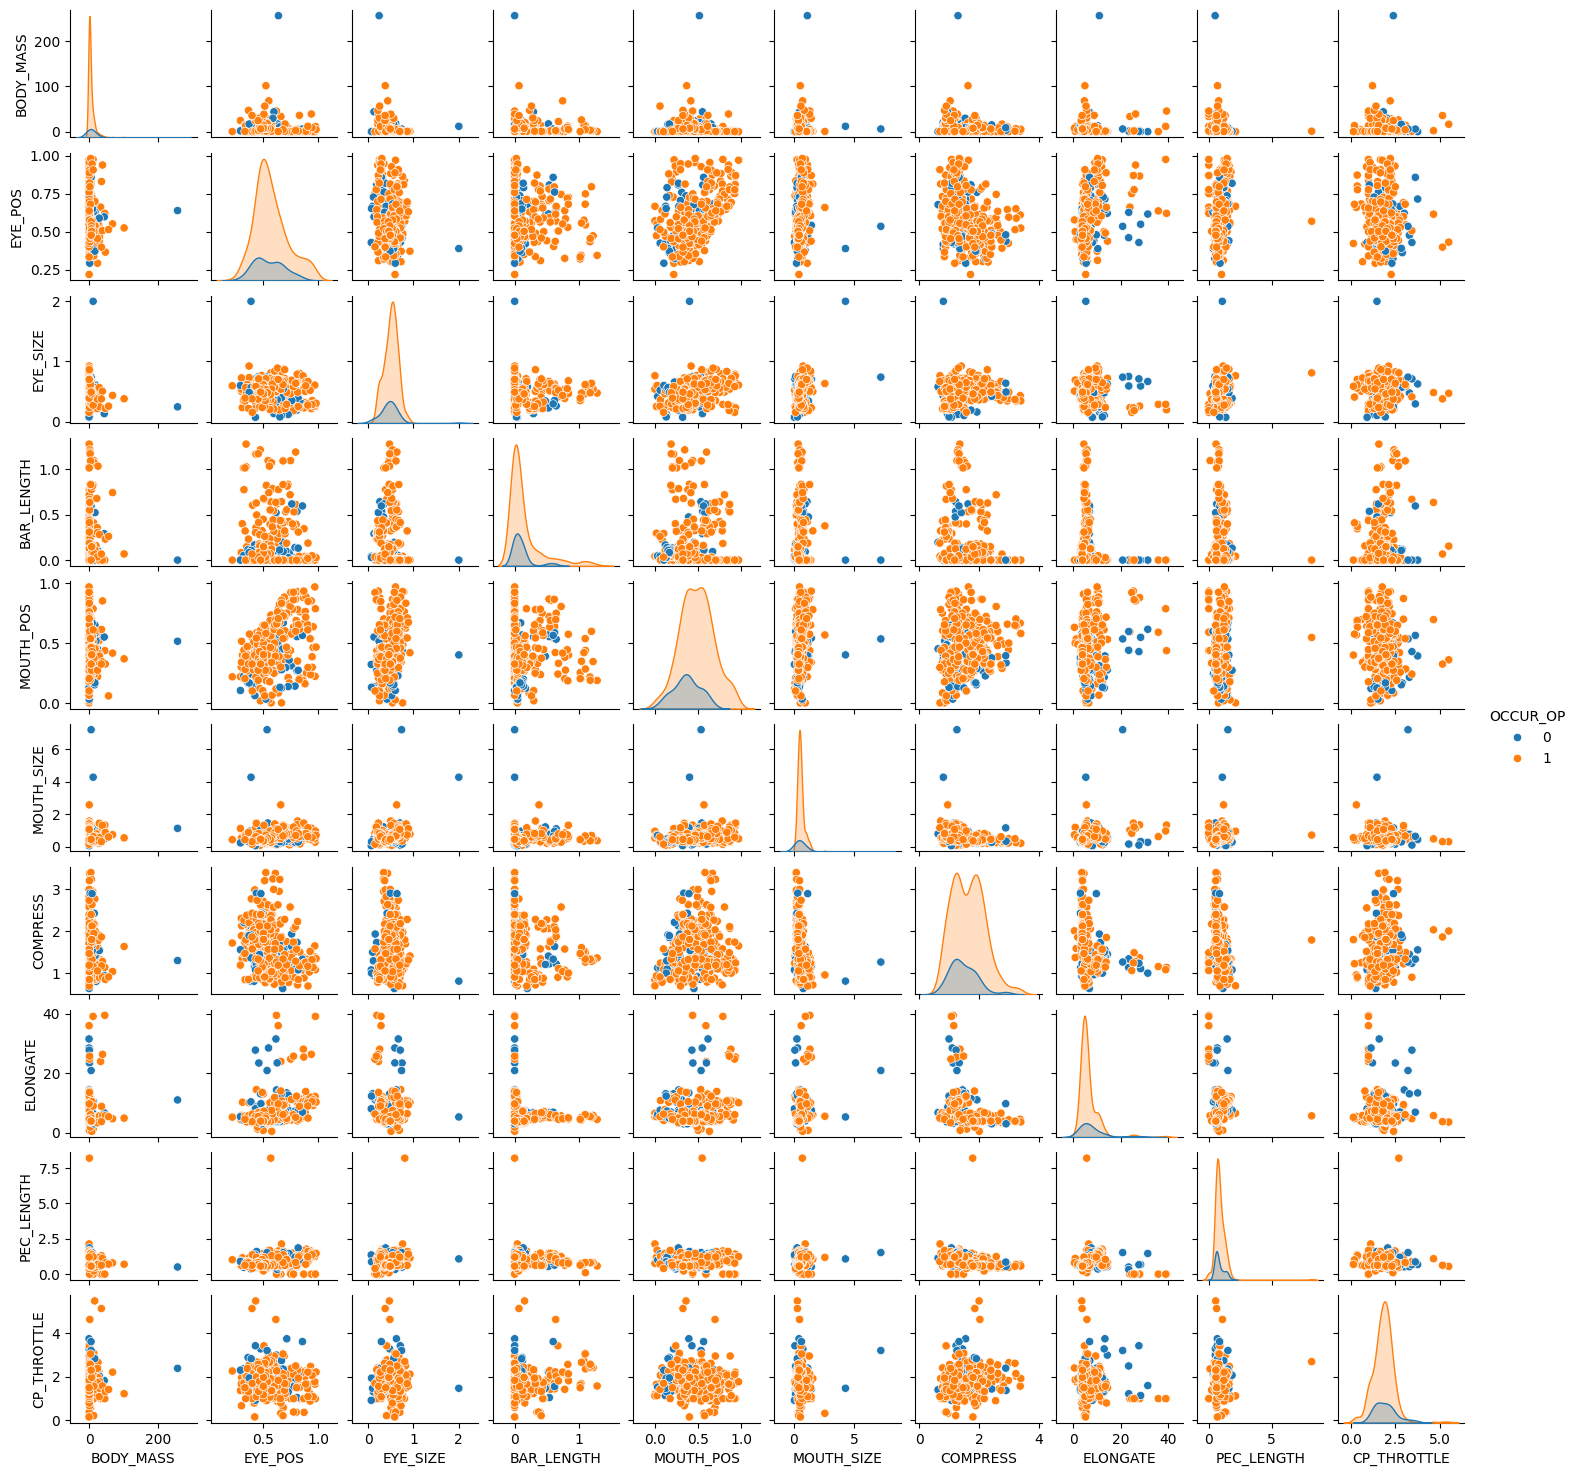

In [89]:
# generate pair plots for all numeric variables with the hue depending on the occurrence
sns.pairplot(fish, hue='OCCUR_OP', height=1.5);

Now, let's start preparing our data. We have to make sure that it is in the correct format to use in our model for dimensionality reduction.

We need to prepare a two-dimensional features matrix and a one-dimensional target matrix. The target matrix is what we want to predict from the features matrix. In this case, our features matrix contains the morphological variables, and the target matrix is whether the fish are present or absent in the streams.

In [90]:
# x is feature matrix, independent variable
# we want to drop string values that are not morphological variables
# we also want to drop OCCUR_OP, because that is the value we want to predict
X_fish = fish.drop(['SITENAME', 'Species', 'OCCUR_OP'], axis=1)
X_fish.shape

(415, 10)

In [91]:
# y is target array, dependent variable
# objective is to predict occurence based on the morphological variables
y_fish = fish['OCCUR_OP']
y_fish.shape

(415,)

We will now create the model using principal component analysis for dimensionality reduction.

In [92]:
model = PCA(n_components=2)            # 1. Instantiate the model
model.fit(X_fish)                      # 2. Fit to data
X_2D = model.transform(X_fish)         # 3. Transform the data (apply dimensionality reduction)

We will add the PCA columns to our fish dataframe and then plot.

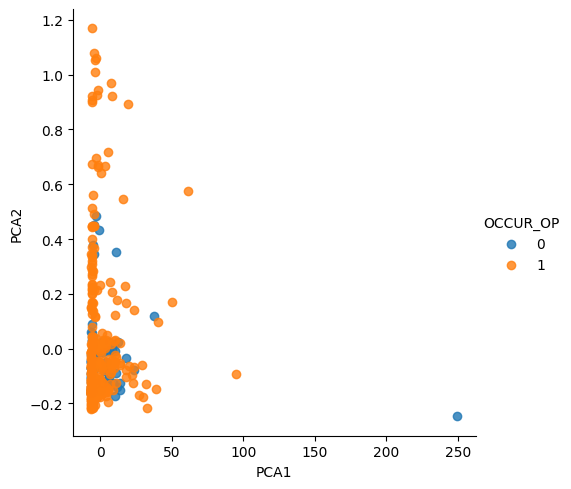

In [97]:
fish['PCA1'] = X_2D[:, 0]
fish['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='OCCUR_OP', data=fish, fit_reg=False)

Just for additional analysis, let's see how our PCA model changes when we only include a few morphological variables: mouth position, bar length, and body mass.

In [94]:
# changing our features matrix to only include three morphological variables
X_fish = X_fish[['MOUTH_POS', 'BAR_LENGTH', 'BODY_MASS']]
X_fish.shape

(415, 3)

In [95]:
model.fit(X_fish)                      # 2. Fit to data
X_2D = model.transform(X_fish)         # 3. Transform the data (apply dimensionality reduction)

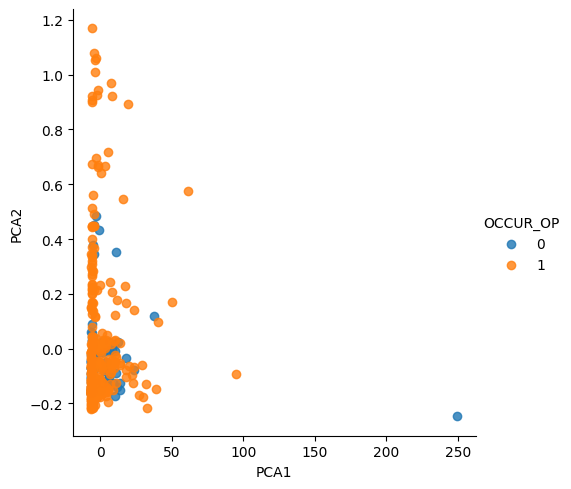

In [96]:
# change values of dataframe columns
fish['PCA1'] = X_2D[:, 0]
fish['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='OCCUR_OP', data=fish, fit_reg=False)